# Tesla Stock price prediction model

In [ ]:
import pandas as pd
import numpy as np
import requests
import yfinance as yf

# -----------------------------
# CONFIGURATION
# -----------------------------
symbol = 'TSLA'
api_key = 'YCTI5M1NDS2OEJU6'  
start_date = '2015-01-01'
end_date = '2024-12-31'

# -----------------------------
# ALPHA VANTAGE FETCH FUNCTIONS
# -----------------------------
def fetch_statement(symbol, function, api_key):
    url = f'https://www.alphavantage.co/query?function={function}&symbol={symbol}&apikey={api_key}'
    r = requests.get(url)
    return r.json()

def clean_financial_df(df):
    df['fiscalDateEnding'] = pd.to_datetime(df['fiscalDateEnding'])
    df.set_index('fiscalDateEnding', inplace=True)
    df = df.drop(columns=[col for col in df.columns if col.lower() in ['reportedcurrency', 'currency']])
    df = df.apply(pd.to_numeric, errors='coerce')
    df.dropna(how='all', inplace=True)
    return df

def get_quarterly_income(symbol, api_key):
    data = fetch_statement(symbol, 'INCOME_STATEMENT', api_key)
    return clean_financial_df(pd.DataFrame(data['quarterlyReports']))

def get_quarterly_balance(symbol, api_key):
    data = fetch_statement(symbol, 'BALANCE_SHEET', api_key)
    return clean_financial_df(pd.DataFrame(data['quarterlyReports']))

def get_quarterly_cashflow(symbol, api_key):
    data = fetch_statement(symbol, 'CASH_FLOW', api_key)
    return clean_financial_df(pd.DataFrame(data['quarterlyReports']))

# -----------------------------
# BUILD TTM + RATIOS
# -----------------------------
def compute_ttm_features(income_df, balance_df, cashflow_df):
    income_df = income_df.sort_index()
    balance_df = balance_df.sort_index()
    cashflow_df = cashflow_df.sort_index()

    df = pd.DataFrame(index=income_df.index)

    # TTM: Income
    df['TTM_Revenue'] = income_df['totalRevenue'].rolling(4).sum()
    df['TTM_NetIncome'] = income_df['netIncome'].rolling(4).sum()
    df['Profit_Margin'] = df['TTM_NetIncome'] / df['TTM_Revenue']

    # Balance Sheet: point-in-time
    df['Total_Assets'] = balance_df['totalAssets']
    df['Total_Liabilities'] = balance_df['totalLiabilities']
    df['Total_Equity'] = balance_df['totalShareholderEquity']
    df['Debt_to_Equity'] = df['Total_Liabilities'] / df['Total_Equity']

    # TTM: Cash Flow
    df['TTM_OperatingCF'] = cashflow_df['operatingCashflow'].rolling(4).sum()
    df['TTM_CapEx'] = cashflow_df['capitalExpenditures'].rolling(4).sum()
    df['TTM_FreeCashFlow'] = df['TTM_OperatingCF'] + df['TTM_CapEx']

    return df.dropna()

# -----------------------------
# DOWNLOAD DAILY STOCK DATA
# -----------------------------
def get_tesla_price_data(symbol, start_date, end_date):
    df = yf.download(symbol, start=start_date, end=end_date)

    # Fix multi-level column names if present
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = ['_'.join(col).strip() for col in df.columns.values]

    df.rename(columns={
        'Open': 'Open',
        'High': 'High',
        'Low': 'Low',
        'Close': 'Close',
        'Volume': 'Volume',
        'Open_TSLA': 'Open',
        'High_TSLA': 'High',
        'Low_TSLA': 'Low',
        'Close_TSLA': 'Close',
        'Volume_TSLA': 'Volume'
    }, inplace=True)

    df = df[['Open', 'High', 'Low', 'Close', 'Volume']]
    df.index.name = 'Date'
    return df

# -----------------------------
# MERGE DAILY & FINANCIALS
# -----------------------------
def merge_financials_with_prices(price_df, ttm_df):
    price_df = price_df.reset_index()
    ttm_df = ttm_df.reset_index()
    merged = pd.merge_asof(
        price_df.sort_values('Date'),
        ttm_df.sort_values('fiscalDateEnding'),
        left_on='Date',
        right_on='fiscalDateEnding',
        direction='backward'
    )
    merged.drop(columns=['fiscalDateEnding'], inplace=True)
    merged.set_index('Date', inplace=True)
    merged = merged.fillna(method='ffill')
    return merged

# -----------------------------
# RUN THE PIPELINE
# -----------------------------
def build_time_series_dataset(symbol, api_key, start_date, end_date):
    print("Fetching income statement...")
    income_df = get_quarterly_income(symbol, api_key)

    print("Fetching balance sheet...")
    balance_df = get_quarterly_balance(symbol, api_key)

    print("Fetching cash flow statement...")
    cashflow_df = get_quarterly_cashflow(symbol, api_key)

    print("Computing TTM features...")
    ttm_df = compute_ttm_features(income_df, balance_df, cashflow_df)

    print("Fetching stock price data...")
    price_df = get_tesla_price_data(symbol, start_date, end_date)

    print("Merging datasets...")
    full_df = merge_financials_with_prices(price_df, ttm_df)

    return full_df

# -----------------------------
# EXECUTE
# -----------------------------
df = build_time_series_dataset(symbol, api_key, start_date, end_date)
print(df.head())

# Optional: Save to CSV
df.to_csv('tesla_time_series_with_income_balance_cashflow.csv')


Fetching income statement...
Fetching balance sheet...
Fetching cash flow statement...
Computing TTM features...
Fetching stock price data...
YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed
<ipython-input-1-9f717060a633>:112: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged = merged.fillna(method='ffill')


Merging datasets...
                 Open       High        Low      Close    Volume  \
Date                                                               
2015-01-02  14.858000  14.883333  14.217333  14.620667  71466000   
2015-01-05  14.303333  14.433333  13.810667  14.006000  80527500   
2015-01-06  14.004000  14.280000  13.614000  14.085333  93928500   
2015-01-07  14.223333  14.318667  13.985333  14.063333  44526000   
2015-01-08  14.187333  14.253333  14.000667  14.041333  51637500   

             TTM_Revenue  TTM_NetIncome  Profit_Margin  Total_Assets  \
Date                                                                   
2015-01-02  3.198356e+09   -294037000.0      -0.091934    5849251000   
2015-01-05  3.198356e+09   -294037000.0      -0.091934    5849251000   
2015-01-06  3.198356e+09   -294037000.0      -0.091934    5849251000   
2015-01-07  3.198356e+09   -294037000.0      -0.091934    5849251000   
2015-01-08  3.198356e+09   -294037000.0      -0.091934    5849251000   

In [ ]:
print(df.info())
print(df.isna().sum())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2515 entries, 2015-01-02 to 2024-12-30
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Open               2515 non-null   float64
 1   High               2515 non-null   float64
 2   Low                2515 non-null   float64
 3   Close              2515 non-null   float64
 4   Volume             2515 non-null   int64  
 5   TTM_Revenue        2515 non-null   float64
 6   TTM_NetIncome      2515 non-null   float64
 7   Profit_Margin      2515 non-null   float64
 8   Total_Assets       2515 non-null   int64  
 9   Total_Liabilities  2515 non-null   int64  
 10  Total_Equity       2515 non-null   int64  
 11  Debt_to_Equity     2515 non-null   float64
 12  TTM_OperatingCF    2515 non-null   float64
 13  TTM_CapEx          2515 non-null   float64
 14  TTM_FreeCashFlow   2515 non-null   float64
dtypes: float64(11), int64(4)
memory usage: 314.4 KB
None
O

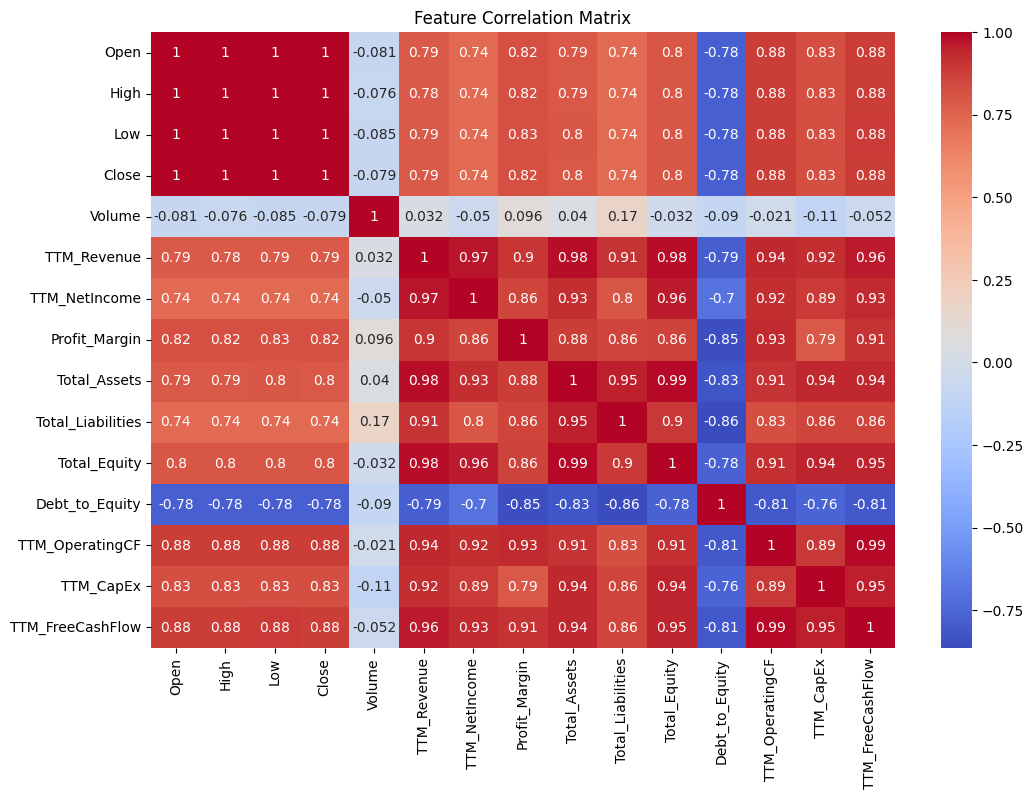

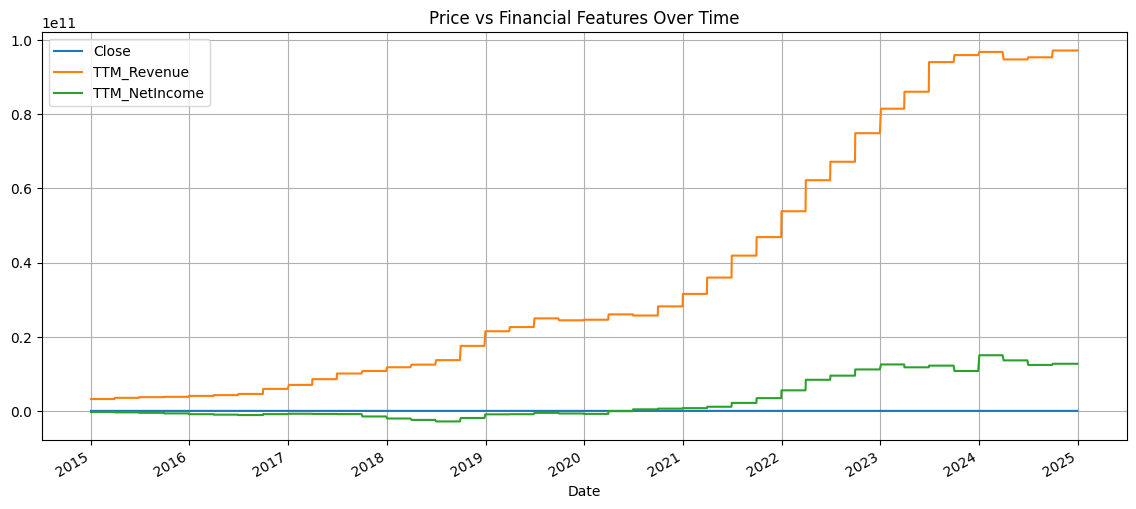

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title("Feature Correlation Matrix")
plt.show()

# Plot target and top features
df[['Close', 'TTM_Revenue', 'TTM_NetIncome']].plot(figsize=(14, 6))
plt.title("Price vs Financial Features Over Time")
plt.grid()
plt.show()

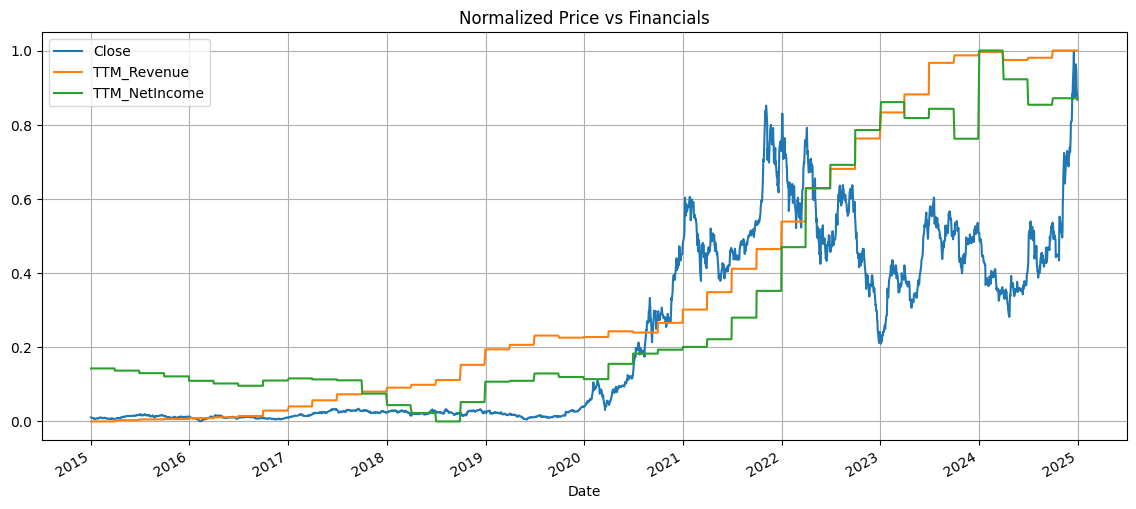

In [ ]:
from sklearn.preprocessing import MinMaxScaler

cols = ['Close', 'TTM_Revenue', 'TTM_NetIncome']
scaler = MinMaxScaler()
scaled = scaler.fit_transform(df[cols])

scaled_df = pd.DataFrame(scaled, columns=cols, index=df.index)
scaled_df.plot(figsize=(14,6), title="Normalized Price vs Financials")
plt.grid()
plt.show()


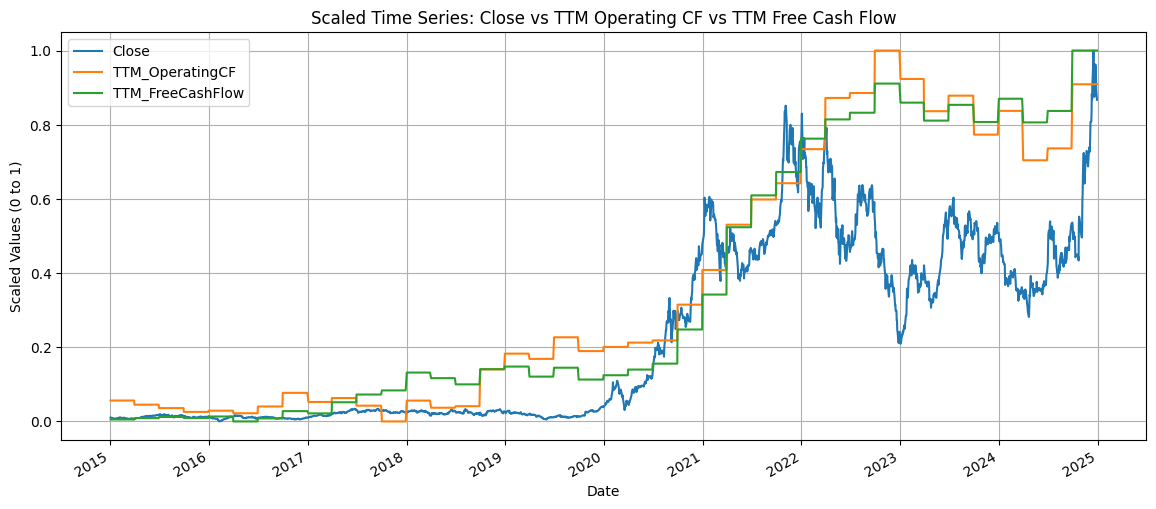

In [ ]:
cols = ['Close', 'TTM_OperatingCF', 'TTM_FreeCashFlow']
df_plot = df[cols].dropna()

# Scale features between 0 and 1 for visual comparison
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df_plot)

# Create a scaled DataFrame
scaled_df = pd.DataFrame(scaled_data, columns=cols, index=df_plot.index)

# Plot
plt.figure(figsize=(14, 6))
scaled_df.plot(ax=plt.gca())
plt.title("Scaled Time Series: Close vs TTM Operating CF vs TTM Free Cash Flow")
plt.ylabel("Scaled Values (0 to 1)")
plt.grid(True)
plt.show()

In [ ]:
!pip install ta
import ta

  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=f5361c38d8b3fb40b05bb11e0449df26aa8bf269bff04a88d2fc3ea6d75cc0f4
  Stored in directory: /root/.cache/pip/wheels/a1/d7/29/7781cc5eb9a3659d032d7d15bdd0f49d07d2b24fec29f44bc4
Successfully built ta


Creating Lag features

In [ ]:
df['Lag_1_Close'] = df['Close'].shift(1)
df['Lag_1_OCF'] = df['TTM_OperatingCF'].shift(1)
df['Lag_1_FCF'] = df['TTM_FreeCashFlow'].shift(1)

Creating 7 and 30 days SMA

In [ ]:
df['SMA_7'] = df['Close'].rolling(window=7).mean()
df['SMA_30'] = df['Close'].rolling(window=30).mean()

In [ ]:
rsi = ta.momentum.RSIIndicator(close=df['Close'], window=14)
df['RSI_14'] = rsi.rsi()

In [ ]:
macd = ta.trend.MACD(close=df['Close'])
df['MACD'] = macd.macd()
df['MACD_Signal'] = macd.macd_signal()
df['MACD_Diff'] = macd.macd_diff()

In [ ]:
features = [
    'Open', 'High', 'Low', 'Close', 'Volume',
    'SMA_7', 'SMA_30', 'RSI_14',
    'MACD', 'MACD_Signal', 'MACD_Diff',
    'TTM_OperatingCF', 'TTM_FreeCashFlow', 'Debt_to_Equity'
]


In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Define your features (inputs for LSTM)
features = [
    'Open', 'High', 'Low', 'Close', 'Volume',
    'SMA_7', 'SMA_30', 'RSI_14',
    'MACD', 'MACD_Signal', 'MACD_Diff',
    'TTM_OperatingCF', 'TTM_FreeCashFlow', 'Debt_to_Equity'
]

# Initialize and fit the scaler
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(df[features])

# Create a new DataFrame with the scaled features
scaled_df = pd.DataFrame(scaled_features, columns=features, index=df.index)

# Add the unscaled target back (so we can train on it)
scaled_df['Target'] = df['Close']  # or df['Target'] if you already defined it


In [ ]:
import numpy as np

def create_sequences(data, seq_length=30, target_column='Target'):
    X, y = [], []
    for i in range(seq_length, len(data)):
        X.append(data.iloc[i - seq_length:i][features].values)  # use only features
        y.append(data.iloc[i][target_column])                   # target is next day's close
    return np.array(X), np.array(y)

X, y = create_sequences(scaled_df, seq_length=30, target_column='Target')


In [ ]:
split_idx = int(len(X) * 0.8)

X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

In [ ]:
df.head()

,Open,High,Low,Close,Volume,TTM_Revenue,TTM_NetIncome,Profit_Margin,Total_Assets,Total_Liabilities,...,TTM_FreeCashFlow,Lag_1_Close,Lag_1_OCF,Lag_1_FCF,SMA_7,SMA_30,RSI_14,MACD,MACD_Signal,MACD_Diff
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-02,14.858000,14.883333,14.217333,14.620667,71466000,3.198356e+09,-294037000.0,-0.091934,5849251000,4937541000,...,912548000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-05,14.303333,14.433333,13.810667,14.006000,80527500,3.198356e+09,-294037000.0,-0.091934,5849251000,4937541000,...,912548000.0,14.620667,-57337000.0,912548000.0,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-06,14.004000,14.280000,13.614000,14.085333,93928500,3.198356e+09,-294037000.0,-0.091934,5849251000,4937541000,...,912548000.0,14.006000,-57337000.0,912548000.0,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-07,14.223333,14.318667,13.985333,14.063333,44526000,3.198356e+09,-294037000.0,-0.091934,5849251000,4937541000,...,912548000.0,14.085333,-57337000.0,912548000.0,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-08,14.187333,14.253333,14.000667,14.041333,51637500,3.198356e+09,-294037000.0,-0.091934,5849251000,4937541000,...,912548000.0,14.063333,-57337000.0,912548000.0,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2515 entries, 2015-01-02 to 2024-12-30
Data columns (total 24 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Open               2515 non-null   float64
 1   High               2515 non-null   float64
 2   Low                2515 non-null   float64
 3   Close              2515 non-null   float64
 4   Volume             2515 non-null   int64  
 5   TTM_Revenue        2515 non-null   float64
 6   TTM_NetIncome      2515 non-null   float64
 7   Profit_Margin      2515 non-null   float64
 8   Total_Assets       2515 non-null   int64  
 9   Total_Liabilities  2515 non-null   int64  
 10  Total_Equity       2515 non-null   int64  
 11  Debt_to_Equity     2515 non-null   float64
 12  TTM_OperatingCF    2515 non-null   float64
 13  TTM_CapEx          2515 non-null   float64
 14  TTM_FreeCashFlow   2515 non-null   float64
 15  Lag_1_Close        2514 non-null   float64
 16  Lag_1_

In [ ]:
!pip install tensorflow

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Define the model
model = Sequential()
model.add(LSTM(units=64, return_sequences=False, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(units=1))  # Predict 1 value: next-day Close

# Compile
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.1,
    shuffle=False,
    verbose=1
)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 2/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 3/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 4/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 5/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 6/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 7/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 8/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 9/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 10/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - l

KeyboardInterrupt: 

In [ ]:
print("NaNs in y_test:", np.isnan(y_test).sum())
print("NaNs in y_pred:", np.isnan(y_pred).sum())

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

model = Sequential()
model.add(LSTM(units=64, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1))  # single output: next-day close

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

history = model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=32,
    validation_split=0.1,
    shuffle=False,
    verbose=1
)


In [ ]:
y_pred = model.predict(X_test).flatten()
print("NaNs in y_pred:", np.isnan(y_pred).sum())


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
NaNs in y_pred: 497


In [ ]:
print("Any NaNs in X_test?", np.isnan(X_test).any())

Any NaNs in X_test? False


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Model definition
model = Sequential()
model.add(LSTM(64, return_sequences=False, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))

# Compile with conservative optimizer
optimizer = Adam(learning_rate=0.001)  # Safe LR
model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

# Train
history = model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=32,
    validation_split=0.1,
    shuffle=False,
    verbose=1
)


Epoch 1/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 2/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 3/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 4/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 5/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 6/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 7/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 8/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 9/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 10/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - l

In [ ]:
y_pred = model.predict(X_test).flatten()
print(" NaNs in y_pred after retraining:", np.isnan(y_pred).sum())

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
 NaNs in y_pred after retraining: 497


In [ ]:
print("Any NaNs in df[features]?", df[features].isna().sum().sum())
print("Any Infs in df[features]?", np.isinf(df[features].values).sum())
print("Max values:", df[features].max())
print("Min values:", df[features].min())

Any NaNs in df[features]? 139
Any Infs in df[features]? 0
Max values: Open                4.759000e+02
High                4.885400e+02
Low                 4.575100e+02
Close               4.798600e+02
Volume              9.140820e+08
SMA_7               4.475886e+02
SMA_30              3.908637e+02
RSI_14              9.419798e+01
MACD                4.053861e+01
MACD_Signal         3.475662e+01
MACD_Diff           1.029617e+01
TTM_OperatingCF     1.603100e+10
TTM_FreeCashFlow    2.534800e+10
Debt_to_Equity      8.472427e+00
dtype: float64
Min values: Open                9.488000e+00
High                1.033133e+01
Low                 9.403333e+00
Close               9.578000e+00
Volume              1.062000e+07
SMA_7               1.008752e+01
SMA_30              1.183391e+01
RSI_14              1.656413e+01
MACD               -2.527133e+01
MACD_Signal        -2.221316e+01
MACD_Diff          -7.678481e+00
TTM_OperatingCF    -1.018754e+09
TTM_FreeCashFlow    7.833390e+08
Debt_to_Equi

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Drop rows with NaNs in any of the features
df = df.dropna(subset=features)

# Normalize
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(df[features])

scaled_df = pd.DataFrame(scaled_features, columns=features, index=df.index)
scaled_df['Target'] = df['Close']  # unscaled close price as target

In [ ]:
def create_sequences(data, seq_length=30):
    X, y = [], []
    for i in range(seq_length, len(data)):
        X.append(data.iloc[i - seq_length:i][features].values)
        y.append(data.iloc[i]['Target'])
    return np.array(X), np.array(y)

X, y = create_sequences(scaled_df)
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [ ]:
model = Sequential([
    LSTM(32, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False),
    Dense(1)
])

model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_split=0.1,
    shuffle=False,
    verbose=1
)

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - loss: 2227.4526 - mae: 24.2175 - val_loss: 56854.9141 - val_mae: 230.9622
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 2016.0057 - mae: 17.2817 - val_loss: 55917.5820 - val_mae: 228.9187
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 1959.9462 - mae: 15.3663 - val_loss: 55278.5195 - val_mae: 227.5150
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 1922.1593 - mae: 14.0226 - val_loss: 54740.8945 - val_mae: 226.3285
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 1891.5629 - mae: 12.9455 - val_loss: 54245.0625 - val_mae: 225.2293
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 1865.2910 - mae: 12.1379 - val_loss: 53773.8438 - val_mae: 224.1800
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 1842.3141 - mae: 11.6769 - val_loss: 53320.2031 - val_mae: 223.1654
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 1822.1218 - mae: 11.4879 - val_loss: 52880.5977 - val_mae: 222.

In [ ]:
y_pred = model.predict(X_test).flatten()
print(" NaNs in y_pred:", np.isnan(y_pred).sum())

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
 NaNs in y_pred: 0


In [ ]:
target_scaler = MinMaxScaler()
scaled_df['Target'] = target_scaler.fit_transform(df[['Close']])  # Scale target

In [ ]:
# Inverse scale the prediction
y_pred = model.predict(X_test)
y_pred_actual = target_scaler.inverse_transform(y_pred)

y_test_actual = df['Close'].iloc[-len(y_pred):].values  # or use your saved original unscaled values


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


In [ ]:
scaled_df['Target'] = df['Close'].shift(-1)
scaled_df.dropna(inplace=True)

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Define features to use
features = [
    'Open', 'High', 'Low', 'Close', 'Volume',
    'SMA_7', 'SMA_30', 'RSI_14',
    'MACD', 'MACD_Signal', 'MACD_Diff',
    'TTM_OperatingCF', 'TTM_FreeCashFlow', 'Debt_to_Equity'
]

# Drop rows with any NaNs in required features
df_clean = df.dropna(subset=features)

# Scale features
feature_scaler = MinMaxScaler()
scaled_features = feature_scaler.fit_transform(df_clean[features])
scaled_features_df = pd.DataFrame(scaled_features, columns=features, index=df_clean.index)

# Scale the target (Close)
target_scaler = MinMaxScaler()
scaled_target = target_scaler.fit_transform(df_clean[['Close']])
scaled_features_df['Target'] = scaled_target

# Final clean frame
final_df = scaled_features_df.dropna()

In [ ]:
import numpy as np

def create_lstm_sequences(data, seq_len, feature_cols, target_col='Target'):
    X, y = [], []
    for i in range(seq_len, len(data)):
        X.append(data[feature_cols].iloc[i-seq_len:i].values)
        y.append(data[target_col].iloc[i])
    return np.array(X), np.array(y)

# Create sequences
sequence_length = 30
X, y = create_lstm_sequences(final_df, sequence_length, feature_cols=features)

# Time-aware split
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

model = Sequential([
    LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=32,
    validation_split=0.1,
    shuffle=False,
    verbose=1
)


Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.0049 - mae: 0.0526 - val_loss: 0.0672 - val_mae: 0.2498
Epoch 2/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0152 - mae: 0.0901 - val_loss: 0.0159 - val_mae: 0.1131
Epoch 3/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0155 - mae: 0.0982 - val_loss: 0.0052 - val_mae: 0.0610
Epoch 4/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0025 - mae: 0.0386 - val_loss: 0.0064 - val_mae: 0.0671
Epoch 5/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0010 - mae: 0.0244 - val_loss: 0.0052 - val_mae: 0.0629
Epoch 6/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0012 - mae: 0.0261 - val_loss: 0.0052 - val_mae: 0.0651
Epoch 7/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 8.8773e-04 - mae: 0.0232 - val_loss: 0.0032 - val_mae: 0.0496
Epoch 8/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 8.3270e-04 - mae: 0.0228 - val_loss: 0.0016 - val_mae: 0.0335
Epoch 9/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0016 -

In [ ]:
# Predict and inverse scale
y_pred_scaled = model.predict(X_test)
y_pred_actual = target_scaler.inverse_transform(y_pred_scaled)
y_test_actual = target_scaler.inverse_transform(y_test.reshape(-1, 1))

# Metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

rmse = np.sqrt(mean_squared_error(y_test_actual, y_pred_actual))
mae = mean_absolute_error(y_test_actual, y_pred_actual)
r2 = r2_score(y_test_actual, y_pred_actual)

print(f" Final Evaluation:")
print(f"R²: {r2:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Final Evaluation:
R²: 0.9060
RMSE: 17.3807
MAE: 13.9222


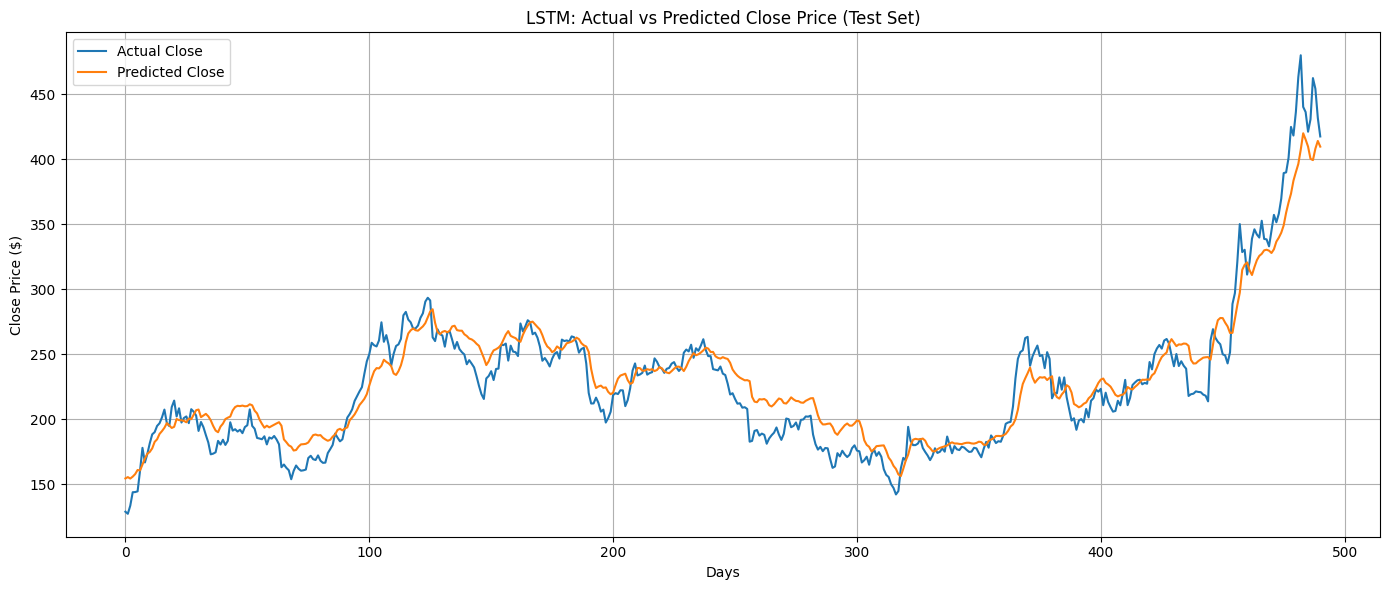

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))
plt.plot(y_test_actual, label='Actual Close')
plt.plot(y_pred_actual, label='Predicted Close')
plt.title("LSTM: Actual vs Predicted Close Price (Test Set)")
plt.xlabel("Days")
plt.ylabel("Close Price ($)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Backtesting

In [ ]:
# Store rolling predictions
rolling_preds = []
rolling_actuals = []

# Copy test set (from earlier)
X_test_rolling = X_test.copy()
y_test_rolling = y_test.copy()

# Loop over test set, one prediction at a time
for i in range(len(X_test_rolling)):
    # Predict the next day using the ith input
    X_input = X_test_rolling[i:i+1]
    pred_scaled = model.predict(X_input)[0][0]

    # Inverse scale
    pred_actual = target_scaler.inverse_transform([[pred_scaled]])[0][0]
    actual = target_scaler.inverse_transform([[y_test_rolling[i]]])[0][0]

    rolling_preds.append(pred_actual)
    rolling_actuals.append(actual)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

rmse = np.sqrt(mean_squared_error(rolling_actuals, rolling_preds))
mae = mean_absolute_error(rolling_actuals, rolling_preds)
r2 = r2_score(rolling_actuals, rolling_preds)

print("📊 Backtest Results (1-step-ahead):")
print(f"R²: {r2:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")


📊 Backtest Results (1-step-ahead):
R²: 0.9060
RMSE: 17.3807
MAE: 13.9222


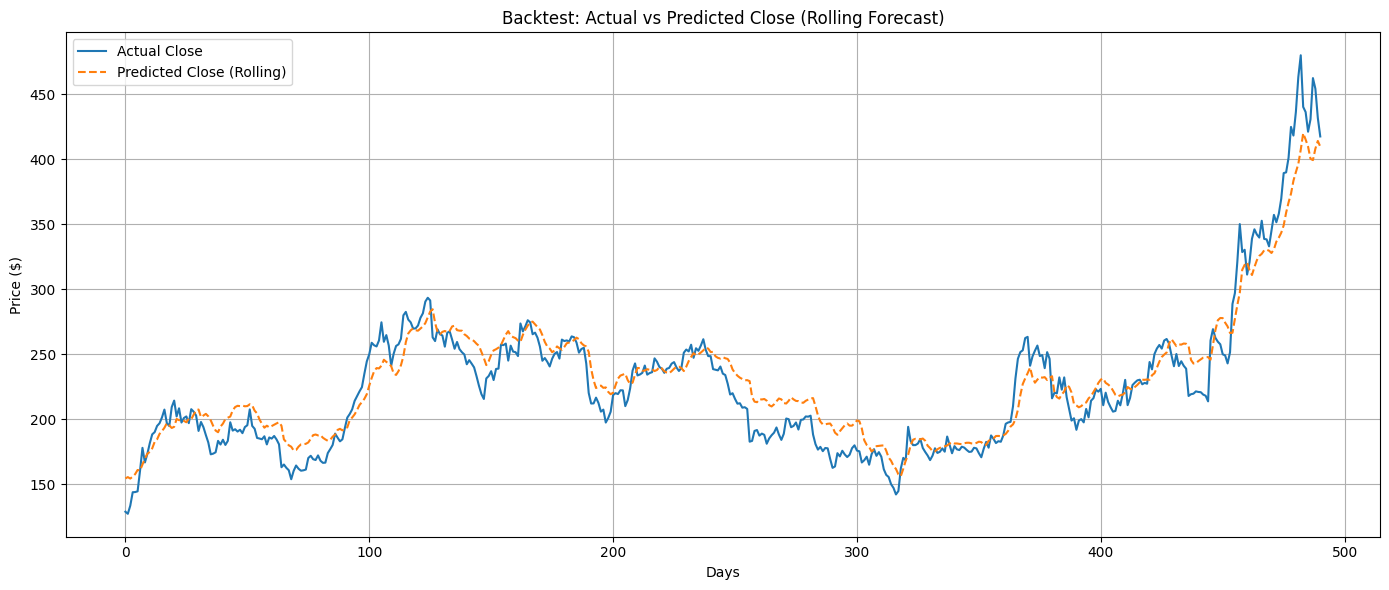

In [ ]:


plt.figure(figsize=(14, 6))
plt.plot(rolling_actuals, label='Actual Close')
plt.plot(rolling_preds, label='Predicted Close (Rolling)', linestyle='--')
plt.title("Backtest: Actual vs Predicted Close (Rolling Forecast)")
plt.xlabel("Days")
plt.ylabel("Price ($)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
model.save("tesla_lstm_model.keras")

import joblib
joblib.dump(feature_scaler, "feature_scaler.save")
joblib.dump(target_scaler, "target_scaler.save")


['target_scaler.save']

In [ ]:
last_sequence = scaled_df[features].iloc[-30:].values.tolist()

import json
with open("input.json", "w") as f:
    json.dump(last_sequence, f)
